## PEPFAR animated line plot

'pepfar_visualization.html' created


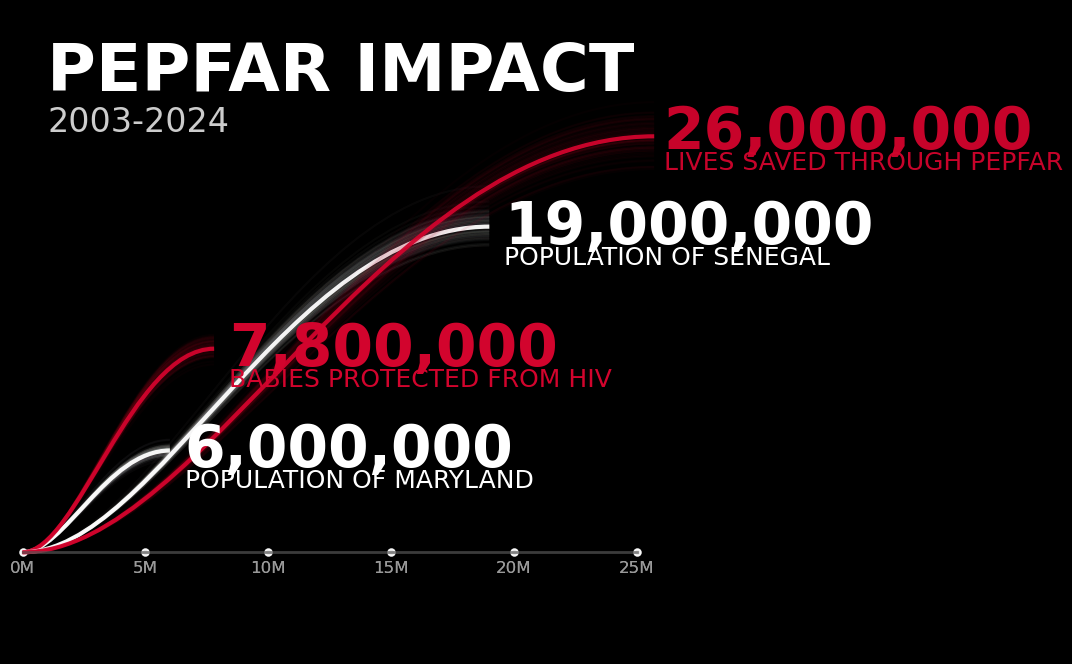

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.animation as animation
import os
import matplotlib as mpl

# Increase the embed limit 
mpl.rcParams['animation.embed_limit'] = 30 

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 7), facecolor='black')

# PEPFAR data
lives_saved = 26000000
babies_saved = 7800000
milestones = [
    {"value": 6000000, "label": "POPULATION OF MARYLAND", "color": "#FFFFFF"},
    {"value": 7800000, "label": "BABIES PROTECTED FROM HIV", "color": "#D2042D"},
    {"value": 19000000, "label": "POPULATION OF SENEGAL", "color": "#FFFFFF"},
    {"value": 26000000, "label": "LIVES SAVED THROUGH PEPFAR", "color": "#D2042D"}]

# flow curve
def create_flow(start_x, end_x, y_target, progress=1.0, num_lines=80, color='#3498db', noise=0.1, alpha_base=0.03):
    paths = []
    
    # endpoint based on progress
    current_end_x = start_x + (end_x - start_x) * progress
    
    # Create multiple semi-transparent lines to form a flow
    for i in range(num_lines):
        y_variation = y_target * (1 + np.random.normal(0, noise/3))
        
        # Create a path 
        path_data = [
            (Path.MOVETO, (start_x, 0)),
            (Path.CURVE4, (start_x + (current_end_x-start_x)/3.5, 0)),
            (Path.CURVE4, (start_x + (current_end_x-start_x)*2/3.5, y_variation * progress)),
            (Path.CURVE4, (current_end_x, y_variation * progress))]
        
        codes, verts = zip(*path_data)
        path = Path(verts, codes)
        # Increasing transparency 
        alpha = alpha_base + (0.01 if i % 10 == 0 else 0)
        c = color
        if isinstance(color, str):
            rgb = mcolors.to_rgb(color)
            c = (min(1.0, rgb[0]*(0.8+0.2*np.random.random())),
                 min(1.0, rgb[1]*(0.8+0.2*np.random.random())),
                 min(1.0, rgb[2]*(0.8+0.2*np.random.random())))
        
        patch = PathPatch(path, facecolor='none', edgecolor=c, linewidth=1.5, alpha=alpha)
        paths.append(patch)
    
    # main curve
    main_path_data = [
        (Path.MOVETO, (start_x, 0)),
        (Path.CURVE4, (start_x + (current_end_x-start_x)/3.5, 0)),
        (Path.CURVE4, (start_x + (current_end_x-start_x)*2/3.5, y_target * progress)),
        (Path.CURVE4, (current_end_x, y_target * progress))]
    
    main_codes, main_verts = zip(*main_path_data)
    main_path = Path(main_verts, main_codes)
    main_patch = PathPatch(main_path, facecolor='none', edgecolor=color, linewidth=3, alpha=0.95)
    paths.append(main_patch)
    
    return paths

# Draw horizontal base line
ax.plot([0, 25000000], [0, 0], color='#555555', linewidth=2, alpha=0.7)

# Title 
ax.text(1000000, 6.8, "PEPFAR IMPACT", fontsize=48, fontweight='bold', color='white')
ax.text(1000000, 6.2, "2003-2024", fontsize=24, color='#cccccc')

# scale
for i in range(0, 26, 5):
    ax.scatter(i * 1000000, 0, color='white', s=25, alpha=0.7)
    ax.text(i * 1000000, -0.3, f"{i}M", ha='center', color='#999999', fontsize=12)

# Positioning the flows at different heights with better spacing
heights = [1.5, 3.0, 4.8, 6.2] 

value_texts = []
label_texts = []

for i, milestone in enumerate(milestones):
    x_offset = 600000
    if i == len(milestones) - 1: 
        x_offset = 100000  #
        
    value_text = ax.text(
        milestone["value"] + x_offset, heights[i], 
        f"{milestone['value']:,}", 
        color=milestone["color"], fontsize=42, fontweight='bold', 
        ha='left', va='center',
        alpha=0 ) # Start invisible
    value_texts.append(value_text)
    
    # Add the label text
    label_text = ax.text(
        milestone["value"] + x_offset, heights[i] - 0.45,
        milestone["label"],
        color=milestone["color"], fontsize=18,
        ha='left', va='center',
        alpha=0)
    label_texts.append(label_text)

# Set axis limits 
ax.set_xlim(-500000, 35000000)
ax.set_ylim(-1.5, 8)
ax.axis('off')

# scale marks
for i in range(0, 35, 5):
    if i <= 25:  
        ax.scatter(i * 1000000, 0, color='white', s=25, alpha=0.7)
        ax.text(i * 1000000, -0.3, f"{i}M", ha='center', color='#999999', fontsize=12)

def animate(frame):
    for artist in ax.patches:
        artist.remove()
        
    # milestone progress
    frames_per_milestone = 90  # Number of frames to complete one milestone animation
    milestone_idx = frame // frames_per_milestone
    milestone_progress = (frame % frames_per_milestone) / frames_per_milestone
    
    if milestone_idx < len(milestones):
        for i in range(milestone_idx):
            paths = create_flow(0, milestones[i]["value"], heights[i], 1.0, 
                                color=milestones[i]["color"])
            for path in paths:
                ax.add_patch(path)
            
            value_texts[i].set_alpha(1.0)
            label_texts[i].set_alpha(1.0)
        
        # Draw current animating milestone
        if milestone_progress > 0:
            paths = create_flow(0, milestones[milestone_idx]["value"], heights[milestone_idx], 
                                milestone_progress, color=milestones[milestone_idx]["color"])
            for path in paths:
                ax.add_patch(path)
                
            # Fade in text as the flow completes
            if milestone_progress > 0.7:
                text_alpha = min(1.0, (milestone_progress - 0.7) * 3.3)
                value_texts[milestone_idx].set_alpha(text_alpha)
                label_texts[milestone_idx].set_alpha(text_alpha)
    
    return ax.patches + value_texts + label_texts

# Create the animation 
ani = FuncAnimation(
    fig, animate, 
    frames=90 * len(milestones),
    interval=1000/20,  # 30 fps
    blit=True)

#figure adjustment
fig.set_figwidth(12)
fig.set_figheight(7)

plt.tight_layout(pad=2.0)
fig.subplots_adjust(right=0.75)  

# HTML output 
html_content = ani.to_jshtml(fps=30)
html_content = html_content.replace('<div class="animation"', '<div style="width:100%; max-width:1200px;" class="animation"')
#with open("pepfar_visualization.html", "w") as f:
#    f.write(html_content)

print("'pepfar_visualization.html' created")